In [14]:
import os
from google.colab import drive
import zipfile
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import matplotlib.pyplot as plt



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "/content/drive/MyDrive/Cat_dog_images.zip"

In [4]:
with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall('/content/data')

In [5]:
data_dir= '/content/data/Cat_dog_images'


In [6]:
IMG_SIZE =224

In [7]:
cpu_count = os.cpu_count()
print(cpu_count)

2


In [8]:
from torch.utils.data import random_split
# from multiprocessing import cpu_count

def get_data_loaders(data_dir, input_size=IMG_SIZE, batch_size=32, val_split=0.2):

    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform) # dataset is torch.utils.data.Dataset object
    print("Dataset classes names:", dataset.classes)
    print("Classes and it's mapped index:", dataset.class_to_idx)
    print("")

    dataset_size = len(dataset)
    print("Total number of images in the dataset:", dataset_size)
    print("")

    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # both are still PyTorch dataset object
    print("Train dataset size:", len(train_dataset))
    print("Validation dataset size:", len(val_dataset))
    print("")

    # The DataLoader is what actually feeds data into the model in batches during training.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=cpu_count)

    print("Datatype of train_loader:", type(train_loader))
    inputs, labels = next(iter(train_loader))
    print(inputs.shape)
    print(labels.shape)

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': train_size, 'val': val_size}
    class_names = dataset.classes

    return dataloaders, dataset_sizes, class_names

In [9]:
dataloaders, dataset_sizes, class_names = get_data_loaders(data_dir)

Dataset classes names: ['cats', 'dogs']
Classes and it's mapped index: {'cats': 0, 'dogs': 1}

Total number of images in the dataset: 210

Train dataset size: 168
Validation dataset size: 42

Datatype of train_loader: <class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [16]:
def train_model(model, dataloaders, dataset_sizes, device, classification_type, num_epochs=10, lr=0.001):
    if classification_type == 1:
        criterion = nn.BCEWithLogitsLoss()
    else:
      criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)
       # Lists to store accuracies
    train_acc_history = []
    val_acc_history = []


    for epoch in range(num_epochs):
        #Each epoch is one full pass over the dataset.
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
          # Two phases per epoch:
          # train: Model learns and updates weights.
          # val: Model evaluates accuracy on unseen data, no learning.

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()
                # reset the gradient to zero
                # THIS MUST NOT BE AVOIDED!

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # forward prop
                    if classification_type == 1:
                        outputs = torch.sigmoid(outputs)
                        preds = (outputs > 0.5).float()
                    else:
                      _, preds = torch.max(outputs, 1)
                    # getting the predicted class and computing loss.

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # backpropagation and updating the parameters

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # calculating each epoch loss and accuracy and normalizes by total number of sample.

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            # Store accuracy
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

    return model, train_acc_history, val_acc_history


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)







cuda


In [21]:
def plot_accuracies(train_acc_history, val_acc_history, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()

Epoch 1/10
--------------------
Train Loss: 0.5935 Acc: 0.8452
Val Loss: 0.6371 Acc: 0.7381
Epoch 2/10
--------------------
Train Loss: 0.5473 Acc: 0.9345
Val Loss: 0.7325 Acc: 0.5714
Epoch 3/10
--------------------
Train Loss: 0.5464 Acc: 0.9405
Val Loss: 0.5473 Acc: 0.8810
Epoch 4/10
--------------------
Train Loss: 0.5398 Acc: 0.9524
Val Loss: 0.7654 Acc: 0.5476
Epoch 5/10
--------------------
Train Loss: 0.5454 Acc: 0.9226
Val Loss: 0.7561 Acc: 0.5476
Epoch 6/10
--------------------
Train Loss: 0.5359 Acc: 0.9583
Val Loss: 0.6771 Acc: 0.5476
Epoch 7/10
--------------------
Train Loss: 0.5325 Acc: 0.9583
Val Loss: 0.6215 Acc: 0.6190
Epoch 8/10
--------------------
Train Loss: 0.5343 Acc: 0.9583
Val Loss: 0.5694 Acc: 0.7619
Epoch 9/10
--------------------
Train Loss: 0.5412 Acc: 0.9583
Val Loss: 0.5641 Acc: 0.8333
Epoch 10/10
--------------------
Train Loss: 0.5317 Acc: 0.9643
Val Loss: 0.5480 Acc: 0.8333


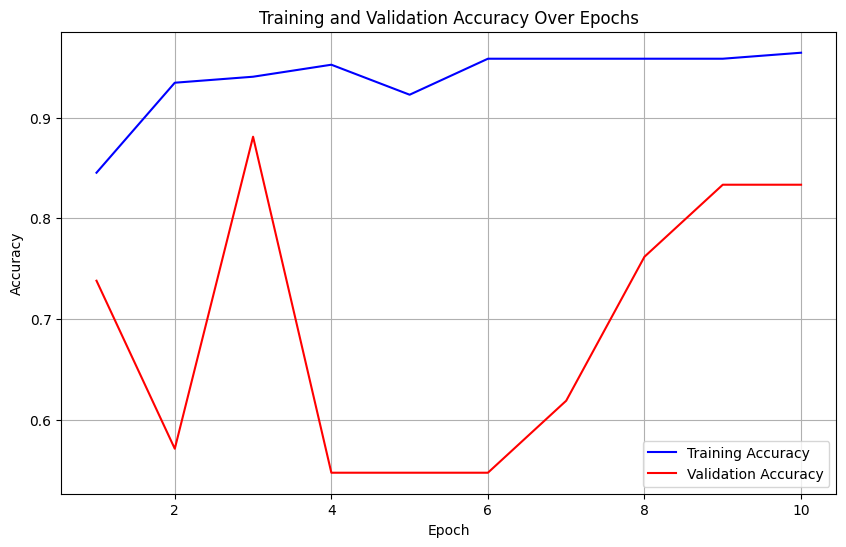

In [22]:
model_name = 'resnet18'  # Change as needed
if len(class_names) == 2:
    num_classes = 1
else:
    num_classes = len(class_names)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = get_model(model_name, num_classes=num_classes)



trained_model, train_acc_history, val_acc_history = train_model(model, dataloaders, dataset_sizes, device, num_classes)
plot_accuracies(train_acc_history, val_acc_history, num_epochs=10)
